In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from google.colab import drive
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
directory = path+ '/Data/images_original'

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])
dataset = datasets.ImageFolder(root=directory, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
test_size = val_size // 2
val_size -= test_size
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
class GenreClassifier(nn.Module):
  def __init__(self):
    super(GenreClassifier, self).__init__()
    self.network = models.vgg19_bn(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features

    # Replace the last layer in the classifier to match the number of classes (10 in this case)
    self.network.classifier[-1] = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
  def forward(self, x):
    return self.network(x)


In [ ]:
model = GenreClassifier()
# Freeze layers outside of the class definition
for param in model.network.features.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in model.network.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.network.classifier.parameters(), lr=0.00001)

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, checkpoint_dir='checkpoints', save_best=True):
    # Create the directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0.0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save checkpoint every epoch
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_accuracy': train_accuracy,
                    'val_accuracy': val_accuracy},
                   checkpoint_path)

        # Save best model based on validation accuracy
        if save_best and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
            torch.save(model.state_dict(), best_checkpoint_path)
            print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

Epoch [1/50], Train Loss: 2.3020, Train Accuracy: 9.59%, Val Loss: 2.2976, Val Accuracy: 8.67%
Best model saved with validation accuracy: 8.67%
Epoch [2/50], Train Loss: 2.2898, Train Accuracy: 13.88%, Val Loss: 2.2838, Val Accuracy: 14.67%
Best model saved with validation accuracy: 14.67%
Epoch [3/50], Train Loss: 2.2731, Train Accuracy: 16.88%, Val Loss: 2.2624, Val Accuracy: 19.33%
Best model saved with validation accuracy: 19.33%
Epoch [4/50], Train Loss: 2.2482, Train Accuracy: 19.74%, Val Loss: 2.2300, Val Accuracy: 26.67%
Best model saved with validation accuracy: 26.67%
Epoch [5/50], Train Loss: 2.2097, Train Accuracy: 24.89%, Val Loss: 2.1836, Val Accuracy: 36.67%
Best model saved with validation accuracy: 36.67%
Epoch [6/50], Train Loss: 2.1458, Train Accuracy: 29.33%, Val Loss: 2.1077, Val Accuracy: 34.67%
Epoch [7/50], Train Loss: 2.0871, Train Accuracy: 33.05%, Val Loss: 2.0272, Val Accuracy: 38.67%
Best model saved with validation accuracy: 38.67%
Epoch [8/50], Train Loss

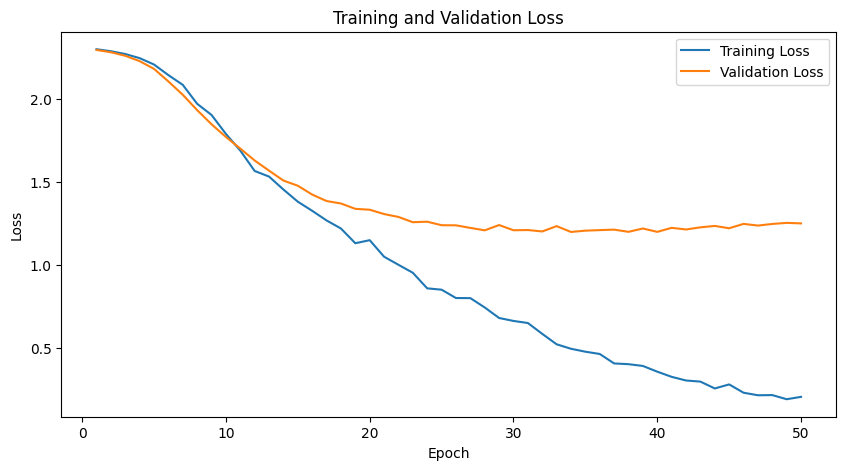

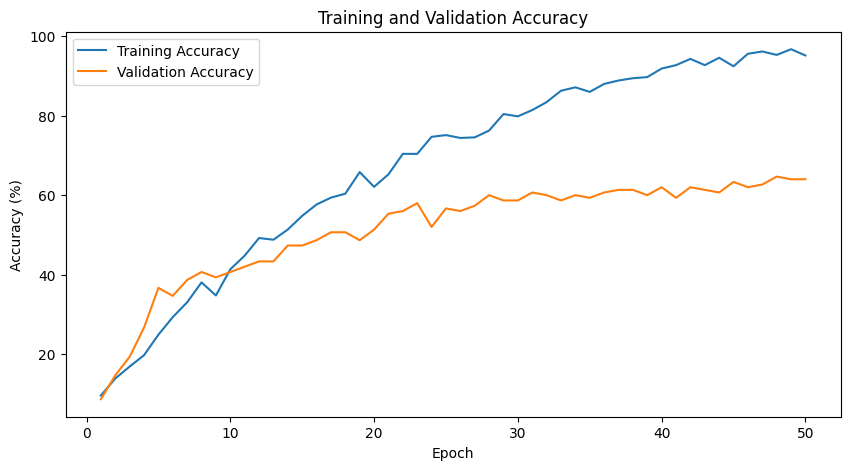

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

In [ ]:
def test_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
test_model(model, test_loader, criterion)

Test Loss: 1.0062, Test Accuracy: 69.33%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, class_names, fontsize=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix with smaller font size for labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")

    # Set font sizes for tick labels
    ax.tick_params(axis='both', labelsize=fontsize)

    plt.title("Confusion Matrix", fontsize=fontsize + 4)
    plt.show()

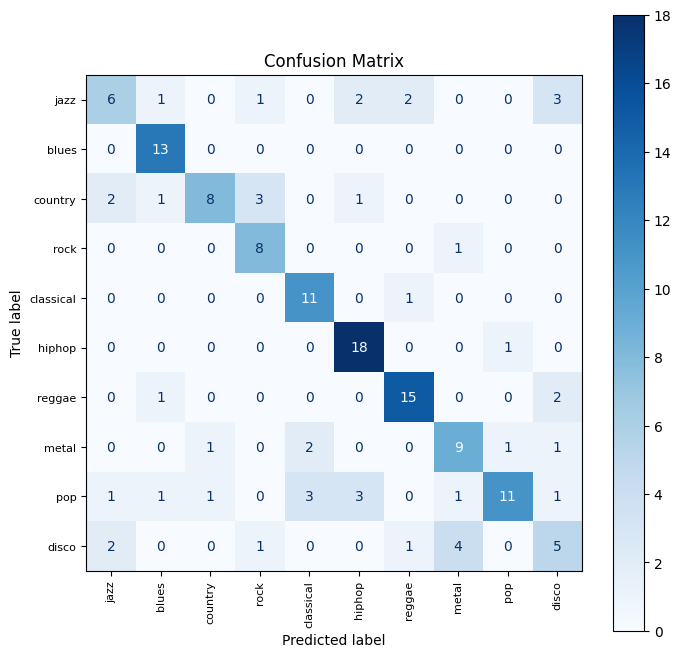

In [ ]:
class_names = ['jazz', 'blues', 'country', 'rock', 'classical', 'hiphop', 'reggae', 'metal', 'pop', 'disco']

plot_confusion_matrix(model, test_loader, class_names)